In [1]:
#separate all samples by subject
import pandas as pd

In [34]:
a = pd.read_csv("/home/alien_yhl/workspace/img_align/data/image_retrieval/subject.csv", sep = "\t", header=None)

In [35]:
a.head()

,0,1
0,1160f10f-e83c-4599-a4c0-a33323d19b18,english
1,13cf87e1-1a28-4395-b990-f0ca93573f17,english
2,1655fea3-a657-420f-bbe4-a1681a87f94f,english
3,18930d24-f9bf-4b02-b184-d9bcf3bbfb6f,english
4,1ffea31c-0a79-47e9-8185-74b646d75613,english


In [40]:
a.loc[0]


0    1160f10f-e83c-4599-a4c0-a33323d19b18
1                                 english
Name: 0, dtype: object

In [42]:
math = []
eng = []
for i in range(len(a)):
    
    if a.loc[i][1] == "english":
        eng.append(a.loc[i][0])
    elif a.loc[i][1] == "math":
        math.append(a.loc[i][0])
    else:
        continue

In [43]:
len(eng)

23952

In [44]:
len(math)

15460

In [46]:
with open("/home/alien_yhl/workspace/img_align/test/english_23952.txt", 'w') as f:
    f.writelines("\n".join(eng))

In [47]:
with open("/home/alien_yhl/workspace/img_align/test/math_15460.txt", 'w') as f:
    f.writelines("\n".join(math))

In [1]:
#analysis and visualize the mktps ratio(of ptks of template)
import glob
import json

from scipy.spatial import distance

In [2]:
filename = "test"
json_list = glob.glob("/home/alien_yhl/downloads/results_json/math_15460/"+"*_result.json")
print(len(json_list))

15460


In [3]:
#calculate euclidean distance
dists = []
failures = []
rdi = []#ratio, distance, isGT
for js in json_list:
    with open(js, 'r') as f:
        data = json.load(f)
    alignment_results = data["alignment_results"]
    try:
        for i in range(len(alignment_results.keys())):
            sample_mkpts = alignment_results[str(i)]["matched_features"]["sample_mkpts"]
            template_mkpts = alignment_results[str(i)]["matched_features"]["template_mkpts"]
            ratio = alignment_results[str(i)]["matched_features"]["mkpts_ratio2template"]
            isGT = alignment_results[str(i)]["isGroundTruthTemplate"]
            dist = 0
            if len(sample_mkpts) != len(template_mkpts):
                print("length not same".format(data["id"]))
                
            for j in range(len(sample_mkpts)):
                dist += distance.euclidean(sample_mkpts[j], template_mkpts[j])
                dist = dist / (j+1)
            dists.append(dist)
            rdi.append((ratio, dist, isGT))
    except:
        failures.append(data["id"])
print(json_list)
print(len(dists))
print(len(failures))

18066
558


math：
    总sample数：15460；失效sample：558；有效sample数：14914
    有效template数：18066，其中正样本数：14914，负样本数：3152
    

In [88]:
#只采用distance阈值
dist_thres = 10
real_d = [x[1] for x in rdi if x[2] == 1]
fake_d = [x[1] for x in rdi if x[2] == 0]
tp = [x for x in fake_d if x>dist_thres]
fp = [x for x in real_d if x>dist_thres]
print("Precision: {}".format(len(tp)/(len(tp)+len(fp))))
print("Recall: {}".format(len(tp)/len(fake_d)))

Precision: 0.9903691813804173
Recall: 0.19574873096446702


In [60]:
#只采用ratio阈值
ratio_thres = 0.042
real_r = [x[0] for x in rdi if x[2] == 1]
fake_r = [x[0] for x in rdi if x[2] == 0]
tp = [x for x in fake_r if x<ratio_thres]
fp = [x for x in real_r if x<ratio_thres]
print("Precision: {}".format(len(tp)/(len(tp)+len(fp))))
print("Recall: {}".format(len(tp)/len(fake_r)))


Precision: 0.9948622139187295
Recall: 0.675761421319797


In [96]:
#同时满足distance阈值60和ratio阈值0.1方才拒识
#real为正确template，但却不应该拒识，注意要与二分类的正样本区分开
ratio_thres = 0.1
dist_thres = 10
real = [(x[0],x[1]) for x in rdi if x[2] == 1]
fake = [(x[0],x[1]) for x in rdi if x[2] == 0]
tp = [x for x in fake if x[0]<ratio_thres and x[1]>dist_thres]
fp = [x for x in real if x[0]<ratio_thres and x[1]>dist_thres]
print("Precision: {}".format(len(tp)/(len(tp)+len(fp))))
print("Recall: {}".format(len(tp)/len(fake)))

Precision: 0.9903069466882067
Recall: 0.1944796954314721


In [97]:
#满足distance阈值60和ratio阈值0.1一个即拒识
ratio_thres = 0.04
dist_thres = 5
real = [(x[0],x[1]) for x in rdi if x[2] == 1]
fake = [(x[0],x[1]) for x in rdi if x[2] == 0]
tp = [x for x in fake if x[0]<ratio_thres or x[1]>dist_thres]
fp = [x for x in real if x[0]<ratio_thres or x[1]>dist_thres]
print("Precision: {}".format(len(tp)/(len(tp)+len(fp))))
print("Recall: {}".format(len(tp)/len(fake)))

Precision: 0.9898523985239852
Recall: 0.6808375634517766


In [22]:
len(real)

14914

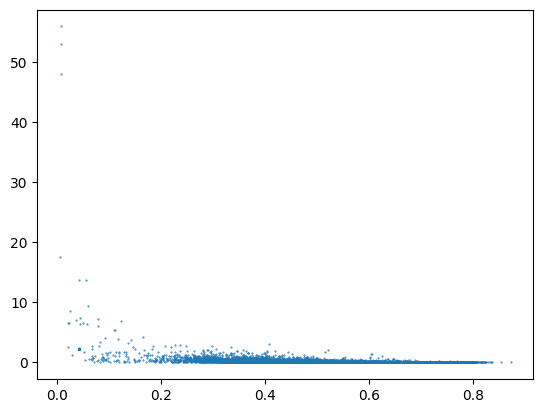

In [5]:

import matplotlib.pyplot as plt
figure, ax = plt.subplots()
r = [x[0] for x in rdi if x[2] == 1]
d = [x[1] for x in rdi if x[2] == 1]
ax.scatter(r,d,s = 0.2)

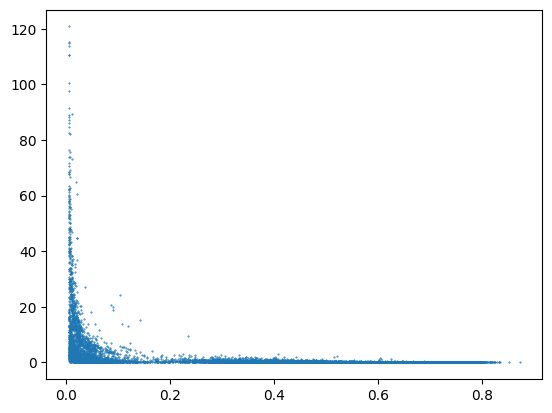

In [51]:
import matplotlib.pyplot as plt
figure, ax = plt.subplots()
r = [x[0] for x in rdi]
d = [x[1] for x in rdi]
ax.scatter(r,d,s = 0.2)

In [10]:
len([x for x in d if x <60])/len(r)

1.0

(array([1.365e+03, 1.287e+03, 7.120e+02, 1.171e+03, 1.806e+03, 8.700e+02,
        4.300e+02, 3.350e+02, 3.250e+02, 3.290e+02, 3.430e+02, 3.210e+02,
        3.030e+02, 3.000e+02, 3.370e+02, 3.420e+02, 3.370e+02, 3.350e+02,
        3.270e+02, 3.210e+02, 3.210e+02, 3.200e+02, 2.780e+02, 2.960e+02,
        2.950e+02, 2.930e+02, 3.120e+02, 2.800e+02, 2.800e+02, 2.990e+02,
        2.970e+02, 2.670e+02, 2.350e+02, 2.480e+02, 2.080e+02, 1.970e+02,
        1.820e+02, 1.540e+02, 1.550e+02, 1.220e+02, 1.150e+02, 9.200e+01,
        1.000e+02, 7.600e+01, 7.100e+01, 6.200e+01, 8.000e+01, 5.700e+01,
        5.100e+01, 4.800e+01, 4.400e+01, 3.900e+01, 2.800e+01, 3.300e+01,
        2.900e+01, 2.800e+01, 1.600e+01, 1.600e+01, 1.400e+01, 1.400e+01,
        1.600e+01, 1.100e+01, 1.300e+01, 1.200e+01, 3.000e+00, 6.000e+00,
        6.000e+00, 4.000e+00, 9.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        5.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+0

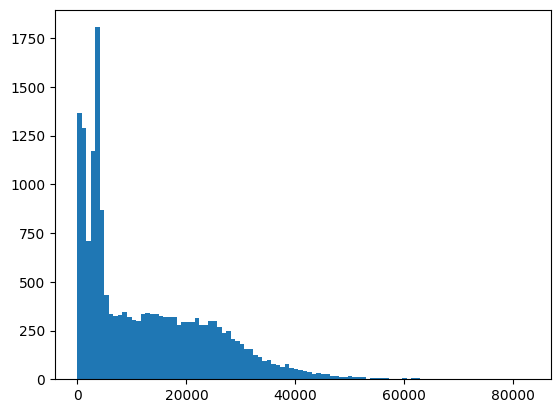

In [39]:
sum(dists)/len(dists)
import matplotlib.pyplot as plt
figure, ax = plt.subplots()
ax.hist(dists, bins = 100)

In [4]:
math_real = []
math_fake = []
for js in json_list:
    with open(js, 'r') as f :
        data = json.load(f)
    name = data["id"]
    alignment_results = data["alignment_results"]
    try:
        for i in range(len(alignment_results.keys())):
            matched_features = alignment_results[str(i)]["matched_features"]
            ratio = matched_features["mkpts_ratio2template"]
            if alignment_results[str(i)]["isGroundTruthTemplate"] == 1:
                math_real.append(ratio)
            else:
                math_fake.append(ratio)
    except:
        continue

    

In [5]:
len(math_real)

14914

In [40]:
len(math_fake)

2134

In [6]:
filename = "test"
json_list = glob.glob("/home/alien_yhl/downloads/results_json/english_23952/"+"*_result.json")
print(len(json_list))
english_real = []
english_fake = []
for js in json_list:
    with open(js, 'r') as f :
        data = json.load(f)
    name = data["id"]
    alignment_results = data["alignment_results"]
    try:
        for i in range(len(alignment_results.keys())):
            matched_features = alignment_results[str(i)]["matched_features"]
            ratio = matched_features["mkpts_ratio2template"]
            if alignment_results[str(i)]["isGroundTruthTemplate"] == 1:
                english_real.append(ratio)
            else:
                english_fake.append(ratio)
    except:
        continue
print(len(english_real))

23952
22164


In [7]:
english_real[0:5]

[0.681640625, 0.646484375, 0.73046875, 0.611328125, 0.56640625]

In [8]:
#visualize
import matplotlib.pyplot as plt

(array([893., 604., 224., 125.,  58.,  36.,  15.,  24.,  21.,  22.,  12.,
          6.,   4.,   6.,   2.,   1.,   3.,   1.,   1.,   0.,   3.,   0.,
          0.,   4.,   3.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   3.,   1.,   3.,   1.,   0.,   0.,   1.,
          1.,   4.,   3.,   5.,   5.,   7.,   2.,   1.,   5.,   2.,   1.,
          1.,   4.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

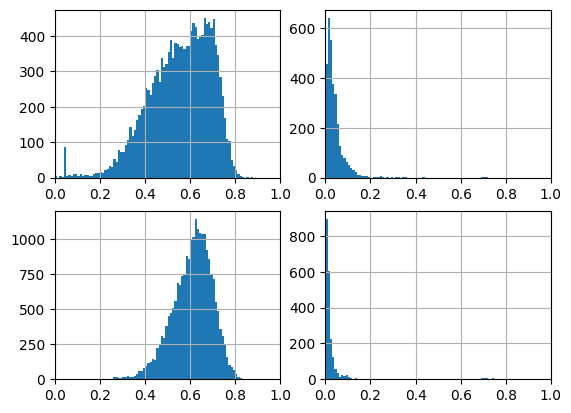

In [23]:
fig, ax = plt.subplots(2,2)
ax[0,0].set_xlim((0,1))
ax[0,0].grid(True);ax[0,1].grid(True);ax[1,0].grid(True);ax[1,1].grid(True)
ax[0,0].hist(math_real, bins = 100,range = (0,1))
ax[0,1].set_xlim((0,1))
ax[0,1].hist(math_fake, bins = 100,range = (0,1))
ax[1,0].set_xlim((0,1))
ax[1,0].hist(english_real, bins = 100,range = (0,1))
ax[1,1].set_xlim((0,1))
ax[1,1].hist(english_fake, bins = 100,range = (0,1))


english: 
    总sample数：23952；有效sample数：22164；
    有效template数：24298；其中正样本数：22164；负样本数：2134
    
math:
    总sample数：15460；有效sample数：14914
    有效template数：18066；其中正样本数：14914；负样本数：3152

In [12]:
[i <= 0.2 for i in math_fake].count(True)

3127

In [20]:
3127/(3152+218)

0.927893175074184

In [15]:
[i <= 0.2 for i in english_real].count(True)

30

In [16]:
[i <= 0.2 for i in english_fake].count(True)

2058

In [17]:
len(english_fake)

2134

In [18]:
2058/(2134+30)

0.9510166358595195